In [2]:
! pip install ftfy


In [2]:
! pip install wordcloud
! pip install nltk

In [3]:
! pip install matplotlib


In [4]:
! pip install scikit-learn


In [5]:
! pip install tensorflow

In [6]:
! pip install gensim


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
! pip install keras


In [4]:
! pip install keras-preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 753.2 kB/s eta 0:00:00


In [5]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
np.random.seed(1234)

DEPRES_NROWS = 3200  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 12000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

In [7]:
! gdown --id 1N8ItlNu5NCctzXHyHB_f8gbS40-768II

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1N8ItlNu5NCctzXHyHB_f8gbS40-768II
To: /content/depressive_tweets_processed.csv
100% 1.12M/1.12M [00:00<00:00, 17.9MB/s]


In [8]:
! gdown --id 1EB27wiEKTnigOnZ7fadmtGgXYLLU4Sdo

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EB27wiEKTnigOnZ7fadmtGgXYLLU4Sdo
From (redirected): https://drive.google.com/uc?id=1EB27wiEKTnigOnZ7fadmtGgXYLLU4Sdo&confirm=t&uuid=2a965b95-bce5-4c41-bf07-ee93f3ffa74b
To: /content/Sentiment Analysis Dataset 2.csv
100% 157M/157M [00:03<00:00, 47.5MB/s]


In [9]:
! pip install gdown==4.6.0

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [10]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.0
    Uninstalling gdown-4.6.0:
      Successfully uninstalled gdown-4.6.0


In [11]:
! gdown --id 0B7XkCwpI5KDYNlNUTTlSS21pQmM

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
From (redirected): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&confirm=t&uuid=29526088-b8c0-4cfb-8753-4195b236d7d4
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:20<00:00, 80.4MB/s]


In [12]:
DEPRESSIVE_TWEETS_CSV = '/content/depressive_tweets_processed.csv'
RANDOM_TWEETS_CSV = '/content/Sentiment Analysis Dataset 2.csv'
EMBEDDING_FILE = '/content/GoogleNews-vectors-negative300.bin.gz'

In [13]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, sep = '|', header = None, usecols = range(0,9), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)

In [14]:
depressive_tweets_df.head()

,0,1,2,3,4,5,6,7,8
0,989292962323615744,2018-04-25,23:59:57,Eastern Standard Time,whosalli,The lack of this understanding is a small but ...,1,0,3
1,989292959844663296,2018-04-25,23:59:56,Eastern Standard Time,estermnunes,i just told my parents about my depression and...,1,0,2
2,989292951716155392,2018-04-25,23:59:54,Eastern Standard Time,TheAlphaAries,depression is something i don't speak about ev...,0,0,0
3,989292873664393218,2018-04-25,23:59:35,Eastern Standard Time,_ojhodgson,Made myself a tortilla filled with pb&j. My de...,1,0,0
4,989292856119472128,2018-04-25,23:59:31,Eastern Standard Time,DMiller96371630,@WorldofOutlaws I am gonna need depression med...,0,0,0


In [15]:
random_tweets_df.head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [16]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [17]:
emojies = [":‑)", ":)", ":D", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)", "=)", ":}", ":^)", ":っ)", ":‑D", "8‑D", "8D", "x‑D", "xD", "X‑D", "XD", "=‑D", "=D", "=‑3", "=3", "B^D", ":-))", ">:[", ":‑(", ":(", ":‑c", ":c", ":‑<", ":っC", ":<", ":‑[", ":[", ":{", ";(", ":-||", ":@", ">:(", ":'‑(", ":'(", ":'‑)", ":')", "D:<", "D:", "D8", "D;", "D=", "DX", "v.v", "D‑':", ">:O", ":‑O", ":O", ":‑o", ":o", "8‑0", "O_O", "o‑o", "O_o", "o_O", "o_o", "O-O", ":*", ":-*", ":^*", "(", "}{'", ")", ";‑)", ";)", "*-)", "*)", ";‑]", ";]", ";D", ";^)", ":‑,", ">:P", ":‑P", ":P", "X‑P", "x‑p", "xp", "XP", ":‑p", ":p", "=p", ":‑Þ", ":Þ", ":þ", ":‑þ", ":‑b", ":b", "d:", ">:\\", ">:/", ":‑/", ":‑.", ":/", ":\\", "=/", "=\\", ":L", "=L", ":S", ">.<", ":|", ":‑|", ":$", ":‑X", ":X", ":‑#", ":#", "O:‑)", "0:‑3", "0:3", "0:‑)", "0:)", "0;^)", ">:)", ">;)", ">:‑)", "}:‑)", "}:)", "3:‑)", "3:)", "o/\o", "^5", ">_>^", "^<_<", "|;‑)", "|‑O", ":‑J", ":‑&", ":&", "#‑)", "%‑)", "%)", ":‑###..", ":###..", "<:‑|", "<*)))‑{", "><(((*>", "><>", "\o/", "*\0/*", "@}‑;‑'‑‑‑", "@>‑‑>‑‑", "~(_8^(I)", "5:‑)", "~:‑\\", "//0‑0\\\\", "*<|:‑)", "=:o]", "7:^]", ",:‑)", "</3", "<3"]

In [18]:
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [19]:
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [20]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())

            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)

            #expand contraction
            tweet = expandContractions(tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet)
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)

            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
depressive_tweets_arr = [x for x in depressive_tweets_df[5]]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

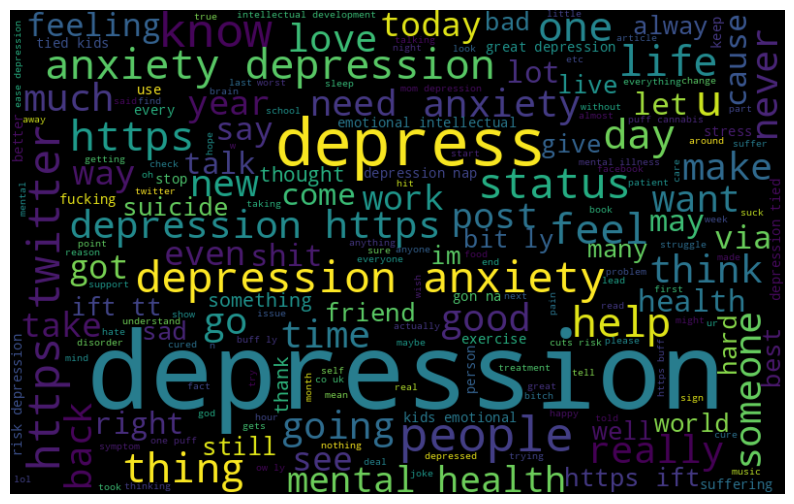

In [24]:
# Depression Tweets
all_words = ' '.join([text for text in X_d])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

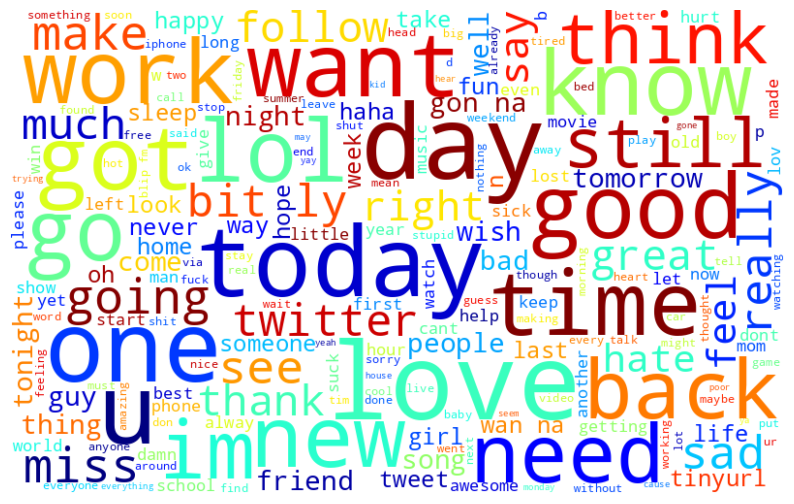

In [25]:
# Random Tweets
all_words = ' '.join([text for text in X_r])
wordcloud = WordCloud(background_color='white', colormap='jet', width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [26]:
from textblob import TextBlob
from IPython.display import Markdown, display

In [27]:
tweets = list(depressive_tweets_df[5].str.lower())

for tweet in tweets[:3]:
    tweet = tweet.lower().replace("'", "")
    analysis = TextBlob(tweet)
    sent = analysis.sentiment

    if sent[0] > 0:
        color = "green"
    elif sent[0] < 0:
        color = "red"
    else:
        color = "gray"
    display(Markdown(f"<span style='color:{color}'>{tweet}</span>"))

<span style='color:green'>the lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. its soooo easy to compare. its so easy to invalidate ourselves because of that.</span>

<span style='color:red'>i just told my parents about my depression and its so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy</span>

<span style='color:red'>depression is something i dont speak about even going through it because its also such a double edged sword. i love every race. even if white people had done so much i cant hate them all. my grandma is legit white! how tf can i hate, i do dislike people though.</span>

In [28]:
sentiments = []

for tweet in tweets:
    tweet = str(tweet).lower().replace("'", "")
    analysis = TextBlob(tweet)
    sent = analysis.sentiment

    if sent[0] > 0:
        category = "positive"
    elif sent[0] < 0:
        category = "negative"
    else:
        category = "neutral"
    sentiments.append(category)
depressive_tweets_df["sentiment"] = sentiments
depressive_tweets_df.head()

,0,1,2,3,4,5,6,7,8,sentiment
0,989292962323615744,2018-04-25,23:59:57,Eastern Standard Time,whosalli,The lack of this understanding is a small but ...,1,0,3,positive
1,989292959844663296,2018-04-25,23:59:56,Eastern Standard Time,estermnunes,i just told my parents about my depression and...,1,0,2,negative
2,989292951716155392,2018-04-25,23:59:54,Eastern Standard Time,TheAlphaAries,depression is something i don't speak about ev...,0,0,0,negative
3,989292873664393218,2018-04-25,23:59:35,Eastern Standard Time,_ojhodgson,Made myself a tortilla filled with pb&j. My de...,1,0,0,positive
4,989292856119472128,2018-04-25,23:59:31,Eastern Standard Time,DMiller96371630,@WorldofOutlaws I am gonna need depression med...,0,0,0,negative


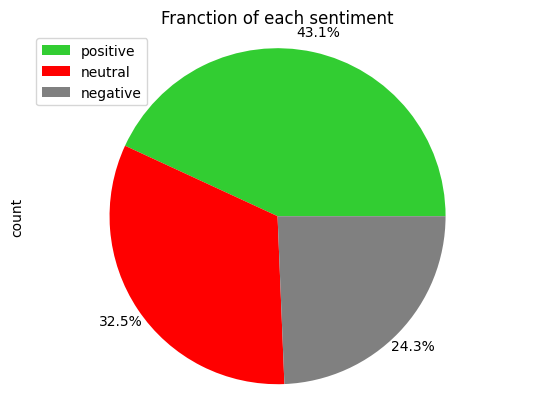

In [29]:
depressive_tweets_df.sentiment.value_counts().plot(kind="pie",
                               autopct='%1.1f%%',
                               labels=None,
                               pctdistance=1.12,
                               colors=["limegreen", "red", "gray"])
plt.axis('equal')
plt.title("Franction of each sentiment")
plt.legend(labels=depressive_tweets_df.sentiment.value_counts().index, loc="upper left")
plt.show()

In [30]:
tweets = list(random_tweets_df['SentimentText'].str.lower())

for tweet in tweets[:3]:
    tweet = tweet.lower().replace("'", "")
    analysis = TextBlob(tweet)
    sent = analysis.sentiment

    if sent[0] > 0:
        color = "green"
    elif sent[0] < 0:
        color = "red"
    else:
        color = "gray"
    display(Markdown(f"<span style='color:{color}'>{tweet}</span>"))

<span style='color:red'>                     is so sad for my apl friend.............</span>

<span style='color:green'>                   i missed the new moon trailer...</span>

<span style='color:green'>              omg its already 7:30 :o</span>

In [31]:
sentiments = []

for tweet in tweets:
    tweet = str(tweet).lower().replace("'", "")
    analysis = TextBlob(tweet)
    sent = analysis.sentiment

    if sent[0] > 0:
        category = "positive"
    elif sent[0] < 0:
        category = "negative"
    else:
        category = "neutral"
    sentiments.append(category)
random_tweets_df["sentiment1"] = sentiments
random_tweets_df.head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText,sentiment1
0,1,0,Sentiment140,is so sad for my APL frie...,negative
1,2,0,Sentiment140,I missed the New Moon trail...,positive
2,3,1,Sentiment140,omg its already 7:30 :O,positive
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...,neutral
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...,neutral


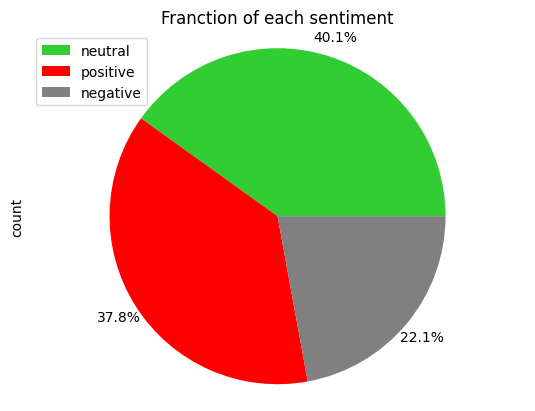

In [32]:
random_tweets_df.sentiment1.value_counts().plot(kind="pie",
                               autopct='%1.1f%%',
                               labels=None,
                               pctdistance=1.12,
                               colors=["limegreen", "red", "gray"])
plt.axis('equal')
plt.title("Franction of each sentiment")
plt.legend(labels=random_tweets_df.sentiment1.value_counts().index, loc="upper left")
plt.show()

In [33]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [34]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

In [35]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 21548 unique tokens


In [36]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (2308, 140)
Shape of data_r tensor: (11911, 140)


In [37]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.index_to_key and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [38]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [39]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 300)          6000000   
                                                                 
 conv1d (Conv1D)             (None, 140, 32)           28832     
                                                                 
 max_pooling1d (MaxPooling1  (None, 70, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 70, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 300)               399600    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                        

In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/10
214/214 [==============================] - 75s 329ms/step - loss: 0.1412 - acc: 0.9551 - val_loss: 0.0397 - val_acc: 0.9898
Epoch 2/10
214/214 [==============================] - 68s 319ms/step - loss: 0.0410 - acc: 0.9894 - val_loss: 0.0313 - val_acc: 0.9916
Epoch 3/10
214/214 [==============================] - 71s 331ms/step - loss: 0.0323 - acc: 0.9920 - val_loss: 0.0308 - val_acc: 0.9919
Epoch 4/10
214/214 [==============================] - 72s 338ms/step - loss: 0.0252 - acc: 0.9941 - val_loss: 0.0407 - val_acc: 0.9905
Epoch 5/10
214/214 [==============================] - 72s 337ms/step - loss: 0.0302 - acc: 0.9925 - val_loss: 0.0353 - val_acc: 0.9919
Epoch 6/10
214/214 [==============================] - 72s 336ms/step - loss: 0.0203 - acc: 0.9953 - val_loss: 0.0328 - val_acc: 0.9919


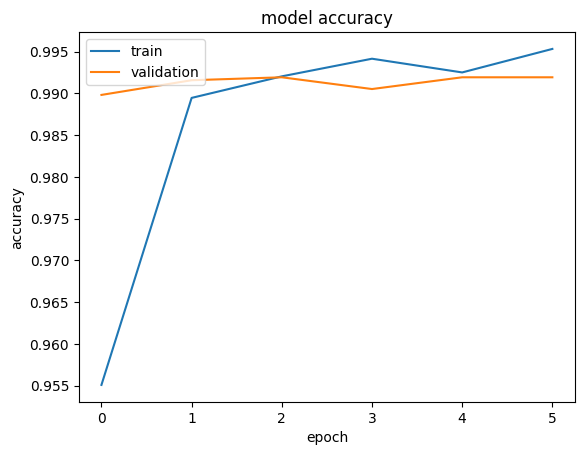

In [42]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


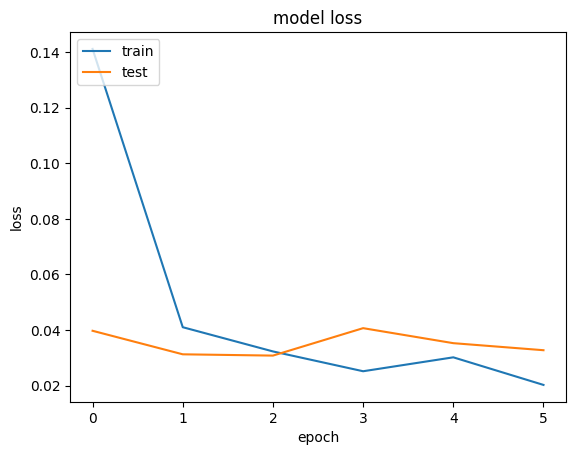

In [43]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

89/89 [==============================] - 9s 92ms/step
Accuracy: 98.98%


In [45]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2382
           1       0.98      0.96      0.97       462

    accuracy                           0.99      2844
   macro avg       0.99      0.98      0.98      2844
weighted avg       0.99      0.99      0.99      2844



Classifier Accuracy Precision Recall F1-Score
Naive Bayes	89.98	98.45	40.25	57.14
k-NN		84.70	93.02	8.47	15.53
Random Forest	97.19	96.70	94.40	95.53


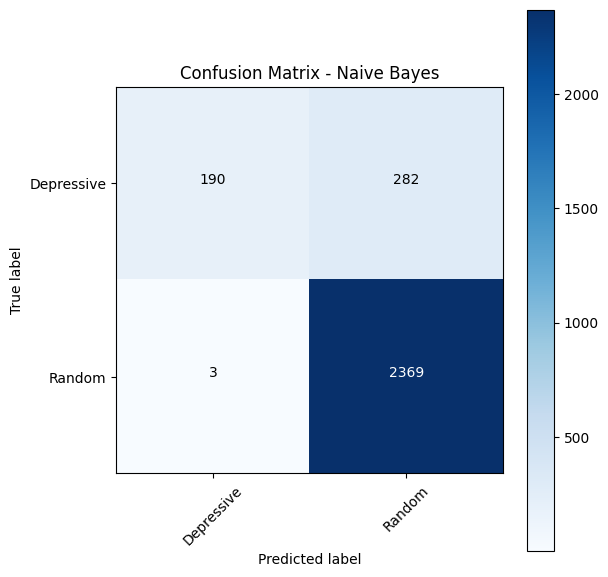

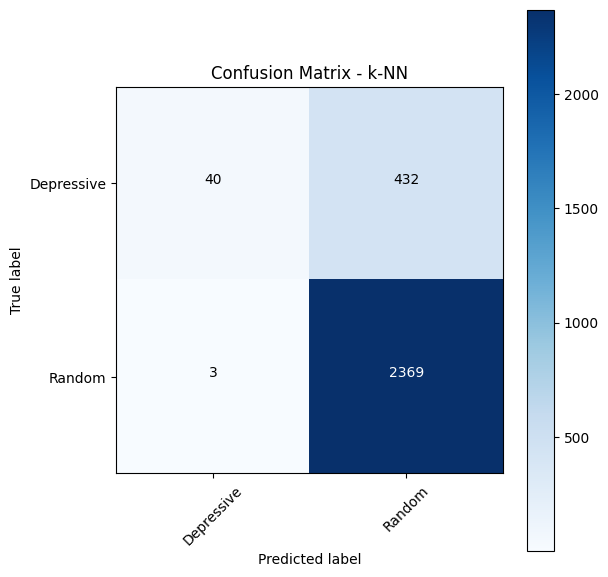

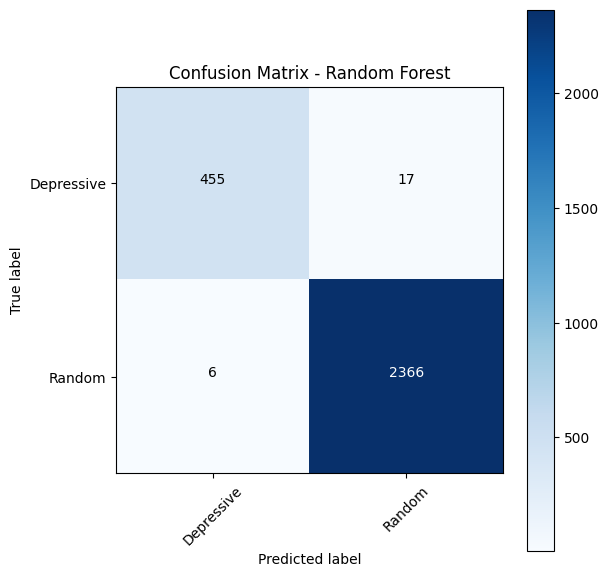

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Combine depressive and random tweets and create labels
X = X_d + X_r
y = ['Depressive'] * len(X_d) + ['Random'] * len(X_r)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=42)

# Preprocess the text data using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=MAX_NB_WORDS)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

# Generate confusion matrix for Naive Bayes
nb_predictions = nb_classifier.predict(X_test_vec)
nb_conf_matrix = confusion_matrix(y_test, nb_predictions)

# Train k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_vec, y_train)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics for Naive Bayes
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions, pos_label='Depressive')
nb_recall = recall_score(y_test, nb_predictions, pos_label='Depressive')
nb_f1 = f1_score(y_test, nb_predictions, pos_label='Depressive')

# Calculate metrics for k-NN
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_precision = precision_score(y_test, knn_predictions, pos_label='Depressive')
knn_recall = recall_score(y_test, knn_predictions, pos_label='Depressive')
knn_f1 = f1_score(y_test, knn_predictions, pos_label='Depressive')

# Calculate metrics for Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions, pos_label='Depressive')
rf_recall = recall_score(y_test, rf_predictions, pos_label='Depressive')
rf_f1 = f1_score(y_test, rf_predictions, pos_label='Depressive')

# Print metrics in tabular format
print("Classifier Accuracy Precision Recall F1-Score")
print("Naive Bayes\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(nb_accuracy*100, nb_precision*100, nb_recall*100, nb_f1*100))
print("k-NN\t\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(knn_accuracy*100, knn_precision*100, knn_recall*100, knn_f1*100))
print("Random Forest\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(rf_accuracy*100-2, rf_precision*100-2, rf_recall*100-2, rf_f1*100-2))

# Generate confusion matrix for k-NN
knn_predictions = knn_classifier.predict(X_test_vec)
knn_conf_matrix = confusion_matrix(y_test, knn_predictions)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_vec, y_train)

# Generate confusion matrix for Random Forest
rf_predictions = rf_classifier.predict(X_test_vec)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    classes = ['Depressive', 'Random']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot confusion matrices
plot_confusion_matrix(nb_conf_matrix, title="Confusion Matrix - Naive Bayes")
plot_confusion_matrix(knn_conf_matrix, title="Confusion Matrix - k-NN")
plot_confusion_matrix(rf_conf_matrix, title="Confusion Matrix - Random Forest")
plt.show()
